# Spark DataFrame - Data Cleaning
There are three options when dealing with missing data: 
1. Changing the data to null
2. Drop the data point (or entire row)
3. Fill it in with a different value

These points are dependent on your requirements. 

Objective: Let's explore our options when it comes to cleaning a basic dataset.

In [1]:
# Must be included at the beginning of each new notebook. Remember to change the app name.
import findspark
findspark.init('/home/ubuntu/spark-3.2.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('missing').getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/10/03 04:41:04 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/10/03 04:41:05 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [6]:
# Importing data which has a header. Schema is automatically configured.
df = spark.read.csv('modify1.csv', header=True, inferSchema=True)
heart_data_situation = spark.read.csv('heart-data-situation.csv', header=True, inferSchema=True)

merged_df = df.join(heart_data_situation, on="id", how="inner")  

# Let's see the data. You'll notice nulls.
merged_df.show()

+---+-----+-----+------+------+------+-----+-----+-----------+----+-----+----+------+------+
| id|index|  age|gender|height|weight|ap_hi|ap_lo|cholesterol|gluc|smoke|alco|active|cardio|
+---+-----+-----+------+------+------+-----+-----+-----------+----+-----+----+------+------+
|  0|    0|18393|     2|   168|  62.0|  110|   80|          1|   1|    0|   0|     1|     0|
|  1|    1|20228|     1|   156|  85.0|  140|   90|          3|   1|    0|   0|     1|     1|
|  2|    2|18857|     1|   165|  64.0|  130|   70|          3|   1|    0|   0|     0|     1|
|  3|    3|17623|     2|   169|  82.0|  150|  100|          1|   1|    0|   0|     1|     1|
|  4|    4|17474|     1|   156|  56.0|  100|   60|          1|   1|    0|   0|     0|     0|
|  8|    5|21914|     1|   151|  67.0|  120|   80|          2|   2|    0|   0|     0|     0|
|  9|    6|22113|     1|   157|  93.0|  130|   80|          3|   1|    0|   0|     1|     0|
| 12|    7|22584|     2|   178|  95.0|  130|   90|          3|   3|   

In [16]:
from pyspark.ml.classification import RandomForestClassifier

feature_cols = ['index', 'id', 'age', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
assembled_data = assembler.transform(merged_df)

rf = RandomForestClassifier(featuresCol="features", labelCol="cardio")
model = rf.fit(assembled_data)

importances = model.featureImportances.toArray()

importances_list = [(feature, float(importance)) for feature, importance in zip(feature_cols, importances)]
importance_df = spark.createDataFrame(importances_list, ["Feature", "Importance"])

importance_df = importance_df.orderBy("Importance", ascending=False)

from pyspark.sql.functions import round

importance_df = importance_df.withColumn("Importance", round(importance_df["Importance"], 2))
importance_df.show()




+-----------+----------+
|    Feature|Importance|
+-----------+----------+
|      ap_hi|      0.53|
|      ap_lo|      0.25|
|        age|       0.1|
|cholesterol|       0.1|
|     weight|      0.01|
|       gluc|      0.01|
|     active|       0.0|
|     height|       0.0|
|      smoke|       0.0|
|       alco|       0.0|
|         id|       0.0|
|      index|       0.0|
+-----------+----------+



In [19]:
merged_df.describe().toPandas()

,summary,id,index,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,count,68056,68056,68056,68056,68056,68056,68056,68056,68056,68056,68056,68056,68056,68056
1,mean,49961.38948806865,34991.75198366051,19467.796329493358,1.3482132361584578,164.41048548254378,73.72453273774539,126.59862466204302,81.28977606676854,1.3629657928764547,1.2239773128012226,0.08756024450452568,0.05310332667215235,0.8037057717174092,0.4936228987892324
2,stddev,28838.84055511243,20198.679156291822,2466.8985187743706,0.4764075075852865,7.825610733050222,13.423933068620316,16.517518537922864,9.398565292233743,0.6778290292171032,0.5698690836303668,0.2826563674162662,0.22424116979742773,0.39719657902829786,0.4999630041132576
3,min,0,0,10798,1,130,30.0,90,40,1,1,0,0,0,0
4,max,99999,69999,23713,2,207,120.0,220,140,3,3,1,1,1,1


In [20]:
from pyspark.sql.functions import col, round

# Calculate BMI
merged_df = merged_df.withColumn("bmi", col("weight") / ((col("height") / 100) ** 2))

# Round BMI to 2 decimal places
merged_df = merged_df.withColumn("bmi", round(col("bmi"), 2))

# Show descriptive statistics for BMI
merged_df.describe("bmi").show()


+-------+------------------+
|summary|               bmi|
+-------+------------------+
|  count|             68056|
|   mean|27.313671829080924|
| stddev| 4.934954139584941|
|    min|             10.73|
|    max|             58.02|
+-------+------------------+



In [22]:
from pyspark.sql.functions import when, col, percentile_approx

# Calculate the median of bmi
median_bmi = merged_df.approxQuantile("bmi", [0.5], 0.0)[0]  # Using approxQuantile to get the median

# Define the conditions for outliers
condition = (col("bmi") < 16) | (col("bmi") > 35)

# Replace outliers with the median value
merged_df = merged_df.withColumn("bmi", when(condition, median_bmi).otherwise(col("bmi")))
merged_df.describe("bmi").show()


+-------+------------------+
|summary|               bmi|
+-------+------------------+
|  count|             68056|
|   mean|26.348999059599507|
| stddev| 3.571605400963905|
|    min|              16.0|
|    max|              35.0|
+-------+------------------+



In [27]:
from pyspark.sql.functions import col, round

# Convert 'age' from days to years and round it to 1 decimal place
merged_df = merged_df.withColumn("age", round(col("age") / 365.0, 1))
merged_df.show()


+---+-----+----+------+------+------+-----+-----+-----------+----+-----+----+------+------+-----+
| id|index| age|gender|height|weight|ap_hi|ap_lo|cholesterol|gluc|smoke|alco|active|cardio|  bmi|
+---+-----+----+------+------+------+-----+-----+-----------+----+-----+----+------+------+-----+
|  0|    0|50.4|     2|   168|  62.0|  110|   80|          1|   1|    0|   0|     1|     0|21.97|
|  1|    1|55.4|     1|   156|  85.0|  140|   90|          3|   1|    0|   0|     1|     1|34.93|
|  2|    2|51.7|     1|   165|  64.0|  130|   70|          3|   1|    0|   0|     0|     1|23.51|
|  3|    3|48.3|     2|   169|  82.0|  150|  100|          1|   1|    0|   0|     1|     1|28.71|
|  4|    4|47.9|     1|   156|  56.0|  100|   60|          1|   1|    0|   0|     0|     0|23.01|
|  8|    5|60.0|     1|   151|  67.0|  120|   80|          2|   2|    0|   0|     0|     0|29.38|
|  9|    6|60.6|     1|   157|  93.0|  130|   80|          3|   1|    0|   0|     1|     0| 26.3|
| 12|    7|61.9|    

In [29]:
# Dropping multiple columns in PySpark
merged_df = merged_df.drop('id', 'index', 'height', 'weight')
merged_df.show()



+----+------+-----+-----+-----------+----+-----+----+------+------+-----+
| age|gender|ap_hi|ap_lo|cholesterol|gluc|smoke|alco|active|cardio|  bmi|
+----+------+-----+-----+-----------+----+-----+----+------+------+-----+
|50.4|     2|  110|   80|          1|   1|    0|   0|     1|     0|21.97|
|55.4|     1|  140|   90|          3|   1|    0|   0|     1|     1|34.93|
|51.7|     1|  130|   70|          3|   1|    0|   0|     0|     1|23.51|
|48.3|     2|  150|  100|          1|   1|    0|   0|     1|     1|28.71|
|47.9|     1|  100|   60|          1|   1|    0|   0|     0|     0|23.01|
|60.0|     1|  120|   80|          2|   2|    0|   0|     0|     0|29.38|
|60.6|     1|  130|   80|          3|   1|    0|   0|     1|     0| 26.3|
|61.9|     2|  130|   90|          3|   3|    0|   0|     1|     1|29.98|
|48.4|     1|  110|   70|          1|   1|    0|   0|     1|     0|28.44|
|54.3|     1|  110|   60|          1|   1|    0|   0|     0|     0|25.28|
|61.7|     1|  120|   80|          1| 

In [32]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import when, count, col
from pyspark.sql import DataFrame
def balance_features(df, binary_features, multiclass_features, binary_class_features):
    balanced_df = df

    # 'active', 'smoke', 'alco'
    for feature in binary_features:
        high_count = df.filter(col(feature) == 0).count()
        low_values = df.filter(col(feature) == 1)
        low_values_upsampled = low_values.sample(True, high_count / low_values.count(), seed=42)
        balanced_df = df.filter(col(feature) == 0).union(low_values_upsampled)

    # 'gluc', 'cholesterol'
    for feature in multiclass_features:
        feature_categories = [row[feature] for row in df.select(feature).distinct().collect()]
        for category in feature_categories:
            high_count = df.filter(col(feature) != category).count()
            low_values = df.filter(col(feature) == category)
            low_values_upsampled = low_values.sample(True, high_count / low_values.count(), seed=42)
            balanced_df = df.filter(col(feature) != category).union(low_values_upsampled)

    # 'gender'
    for feature in binary_class_features:
        high_count = df.filter(col(feature) == 1).count()
        low_values = df.filter(col(feature) == 2)
        low_values_upsampled = low_values.sample(True, high_count / low_values.count(), seed=42)
        balanced_df = df.filter(col(feature) == 1).union(low_values_upsampled)

    return balanced_df

# Create a Spark DataFrame from your original data source
# e.g., merged_df = spark.read.csv("path_to_your_data.csv", header=True, inferSchema=True)

binary_features = ['active', 'smoke', 'alco']
multiclass_features = ['gluc', 'cholesterol']
binary_class_features = ['gender']

balanced_df = balance_features(merged_df, binary_features, multiclass_features, binary_class_features)



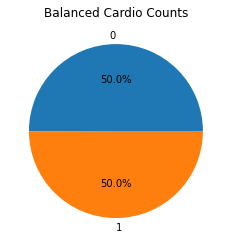

In [36]:
from pyspark.sql.functions import col
import matplotlib.pyplot as plt

# Balance 'cardio'
cardio_0_count = balanced_df.filter(col('cardio') == 0).count()
cardio_1_values = balanced_df.filter(col('cardio') == 1)
cardio_1_upsampled = cardio_1_values.sample(True, cardio_0_count / cardio_1_values.count(), seed=42)
balanced_df = balanced_df.filter(col('cardio') == 0).union(cardio_1_upsampled)

# Check counts for visualization
cardio_counts = balanced_df.groupby('cardio').agg(count('cardio').alias('count')).collect()

# Using matplotlib to plot
labels = [row['cardio'] for row in cardio_counts]
sizes = [row['count'] for row in cardio_counts]
plt.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.title('Balanced Cardio Counts')
plt.show()


In [38]:
balanced_df.describe().toPandas()

,summary,age,gender,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi
0,count,89134,89134,89134,89134,89134,89134,89134,89134,89134,89134,89134
1,mean,53.32032782103335,1.4972849866493145,126.98749074427266,81.51791684430184,1.3563511118091862,1.222137455965176,0.12017860748984675,0.0656988354612157,0.8032176273924653,0.49984293311194383,26.294938743913452
2,stddev,6.8057299794781,0.49999543339627717,16.510607156574192,9.359611881119623,0.673760567001296,0.5682491513990103,0.32517210221756665,0.24775630595834697,0.39756866543166625,0.5000027801193122,3.544348837773566
3,min,29.6,1,90,40,1,1,0,0,0,0,16.0
4,max,65.0,2,220,140,3,3,1,1,1,1,35.0


Great work! At this stage, we're pretty much done with understanding DataFrames. You can now move on to applying an algorithm. We recommend going through linear regression, then logistic regression and finishing off with tree methods. It's best to start with the documentation example before moving to the advanced example. 

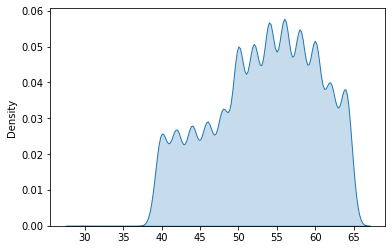

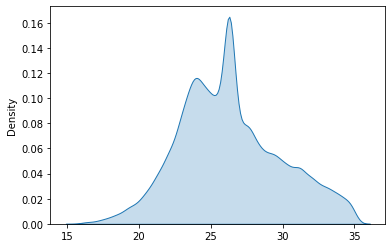

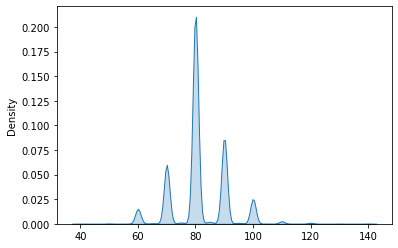

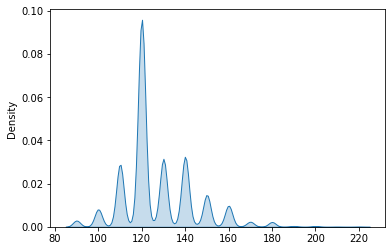

In [40]:

from pyspark.sql import functions as F
from pyspark.sql.types import DoubleType
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew

# Assuming 'balanced_df' is your DataFrame

def plot_kde(df, column_name):
    sampled_data = df.select(column_name).rdd.map(lambda row: row[0]).collect()
    sns.kdeplot(sampled_data, shade=True)
    plt.show()

# Plot KDE plots
plot_kde(balanced_df, 'age')
plot_kde(balanced_df, 'bmi')
plot_kde(balanced_df, 'ap_lo')
plot_kde(balanced_df, 'ap_hi')

# Calculate skewness
def calculate_skew(df, column_name):
    sampled_data = df.select(column_name).rdd.map(lambda row: row[0]).collect()
    return skew(sampled_data)

skew_age = calculate_skew(balanced_df, 'age')
skew_bmi = calculate_skew(balanced_df, 'bmi')
skew_ap_lo = calculate_skew(balanced_df, 'ap_lo')
skew_ap_hi = calculate_skew(balanced_df, 'ap_hi')

In [42]:
print("Age Skewness:", skew_age)
print("BMI Skewness:", skew_bmi)
print("ap_lo Skewness:", skew_ap_lo)
print("ap_hi Skewness:", skew_ap_hi)

Age Skewness: -0.29560255600382285
BMI Skewness: 0.2917896901688652
ap_lo Skewness: 0.38041770745935255
ap_hi Skewness: 0.9591071075674875


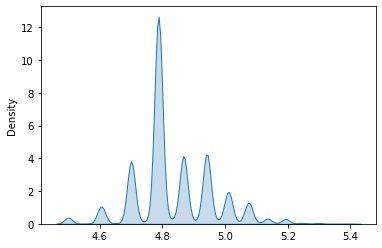

ap_hi Skewness (after transformation): 0.4720612429213762


In [43]:
balanced_df = balanced_df.withColumn('ap_hi', F.log('ap_hi'))
plot_kde(balanced_df, 'ap_hi')
skew_ap_hi_after = calculate_skew(balanced_df, 'ap_hi')
print("ap_hi Skewness (after transformation):", skew_ap_hi_after)

In [44]:
print("Age Skewness:", skew_age)
print("BMI Skewness:", skew_bmi)
print("ap_lo Skewness:", skew_ap_lo)
print("ap_hi Skewness:", skew_ap_hi_after)

Age Skewness: -0.29560255600382285
BMI Skewness: 0.2917896901688652
ap_lo Skewness: 0.38041770745935255
ap_hi Skewness: 0.4720612429213762


In [50]:
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Convert feature columns to a single vector column
feature_columns = ['bmi', 'ap_lo', 'ap_hi']
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
data = assembler.transform(balanced_df)

# Split the data
(train_data, test_data) = data.randomSplit([0.7, 0.3])

# Create and fit the Decision Tree model
tree_model = DecisionTreeClassifier(featuresCol="features", labelCol="cardio")
model = tree_model.fit(train_data)

# Make predictions
predictions = model.transform(test_data)

# 2. Compute classification metrics
evaluator = MulticlassClassificationEvaluator(labelCol="cardio", predictionCol="prediction")

accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
f1 = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})

print(f"Accuracy: {accuracy}")
print(f"Weighted Precision: {precision}")
print(f"Weighted Recall: {recall}")
print(f"F1 Score: {f1}")

# 3. Compute the confusion matrix
tp = predictions.filter("cardio = 1 and prediction = 1").count()
tn = predictions.filter("cardio = 0 and prediction = 0").count()
fp = predictions.filter("cardio = 0 and prediction = 1").count()
fn = predictions.filter("cardio = 1 and prediction = 0").count()

print(f"Confusion Matrix:\n[[{tn}, {fp}],\n [{fn}, {tp}]]")



Accuracy: 0.7142644264799016
Weighted Precision: 0.724202450574497
Weighted Recall: 0.7142644264799016
F1 Score: 0.7108105501817769


Confusion Matrix:
[[11087, 2402],
 [5268, 8086]]


In [49]:
print(f"Accuracy: {accuracy}")
print(f"Weighted Precision: {precision}")
print(f"Weighted Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.7118033402139238


NameError: name 'precision' is not defined